In [1]:
# if needed in Colab run the following command:
# !pip install torch==2.2.0 torchtext==0.17.0
# !pip install portalocker>=2.0.0
# !pip install transformers 
# !pip install torchmetrics

import torch
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from torchmetrics.classification import BinaryF1Score
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import time
import hashlib
from transformers import DistilBertTokenizerFast, DistilBertModel

In [ ]:
# Takes a long time...
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip > /dev/null 2>&1

'wget' is not recognized as an internal or external command,
operable program or batch file.
The system cannot find the path specified.


In [2]:
# Global variables
BATCH_SIZE = 8
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 1
DROPOUT = 0.2
NUM_LAYERS = 2
NUM_EPOCHS = 5
GLOVE_PATH = "glove.6B.100d.txt"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


## Building Vocab using tokenizer

In [3]:
# Build vocab
def yield_tokens(data_iter, tokenizer, model_name='basic'):
    if model_name == 'basic':
        for _, text in data_iter:
            yield tokenizer(text)
            
train_iter = IMDB(split='train')

### Basic vocab

In [4]:
# Load tokenizer
basic_tokenizer = get_tokenizer("basic_english")        
basic_vocab = build_vocab_from_iterator(yield_tokens(train_iter, basic_tokenizer, model_name='basic'), specials=['<unk>'])
basic_vocab.set_default_index(basic_vocab['<unk>'])  # Default index for unknown words
BASIC_VOCAB_SIZE = len(basic_vocab)
BASIC_PAD_IDX = basic_vocab['<unk>'] # 0
print(f"Basic vocab length: {BASIC_VOCAB_SIZE}")

Basic vocab length: 100683


## Checking datas and building loaders

In [5]:
# Function for calculating a unique hash for each data item
def hash_data(data):
    _, text = data
    return hashlib.md5(text.encode('utf-8')).hexdigest()

# Deletes duplicates in the dataset
def remove_duplicates(data):
    seen = set() 
    unique_data = [] 
    for item in data:
        data_hash = hash_data(item)  
        if data_hash not in seen:
            seen.add(data_hash)  
            unique_data.append(item)
    return unique_data

def verify_no_overlap(train_datas, val_datas, test_datas, hash_fn):
    # Hashes calculations
    train_hashes = set(hash_fn(data) for data in train_datas)
    val_hashes = set(hash_fn(data) for data in val_datas)
    test_hashes = set(hash_fn(data) for data in test_datas)
    
    assert train_hashes.isdisjoint(val_hashes), "Overlap between train and validation"
    assert train_hashes.isdisjoint(test_hashes), "Overlap between train and test"
    assert val_hashes.isdisjoint(test_hashes), "Overlap between validation and test"
    
    print("The data sets are well disjointed.")

In [6]:
train_iter = IMDB(split='train')
test_iter = IMDB(split='test')
all_data = list(train_iter) + list(test_iter)
all_data = remove_duplicates(all_data)
all_hashes = [hash_data(data) for data in all_data]

# Check for duplicates
if len(all_hashes) != len(set(all_hashes)):
    print("Caution: Duplicate data exists!")
else:
    print("All data is unique.")

All data is unique.


In [7]:
TRAIN_SIZE = int(0.8 * len(all_data))
VAL_SIZE = int(0.1 * len(all_data))
TEST_SIZE = len(all_data) - TRAIN_SIZE - VAL_SIZE

train_datas, val_datas, test_datas = random_split(all_data, [TRAIN_SIZE, VAL_SIZE, TEST_SIZE])
verify_no_overlap(train_datas, val_datas, test_datas, hash_fn=hash_data) # Useless if we called 'remove_duplicates' previously

The data sets are well disjointed.


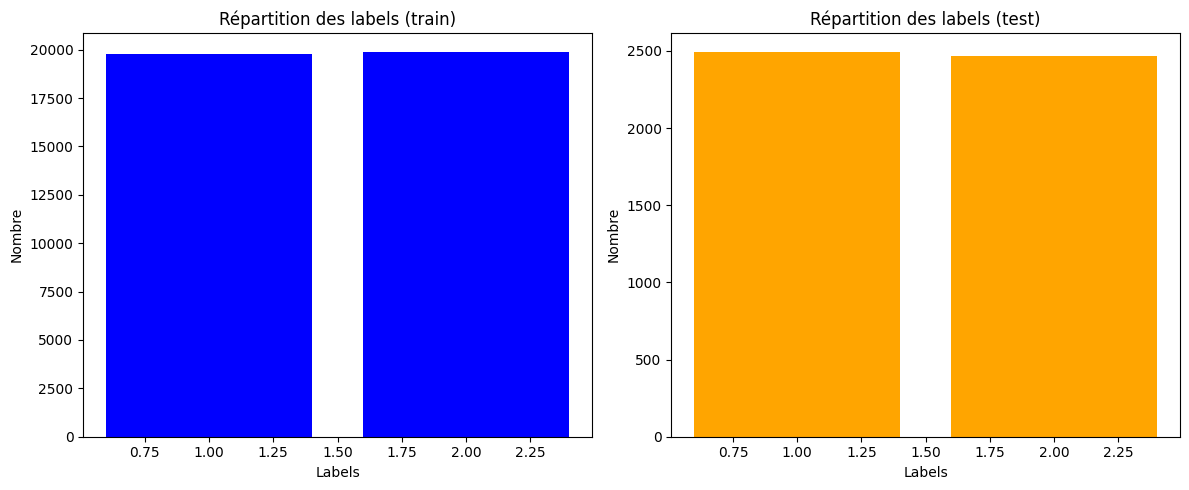

[1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 

In [8]:
from collections import Counter
import matplotlib.pyplot as plt

# Distribution des labels
train_labels = [label for label, _ in train_datas]
test_labels = [label for label, _ in test_datas]

train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(train_label_counts.keys(), train_label_counts.values(), color='blue')
axes[0].set_title('Répartition des labels (train)')
axes[0].set_xlabel('Labels')
axes[0].set_ylabel('Nombre')

axes[1].bar(test_label_counts.keys(), test_label_counts.values(), color='orange')
axes[1].set_title('Répartition des labels (test)')
axes[1].set_xlabel('Labels')
axes[1].set_ylabel('Nombre')

plt.tight_layout()
plt.show()
print(train_labels)


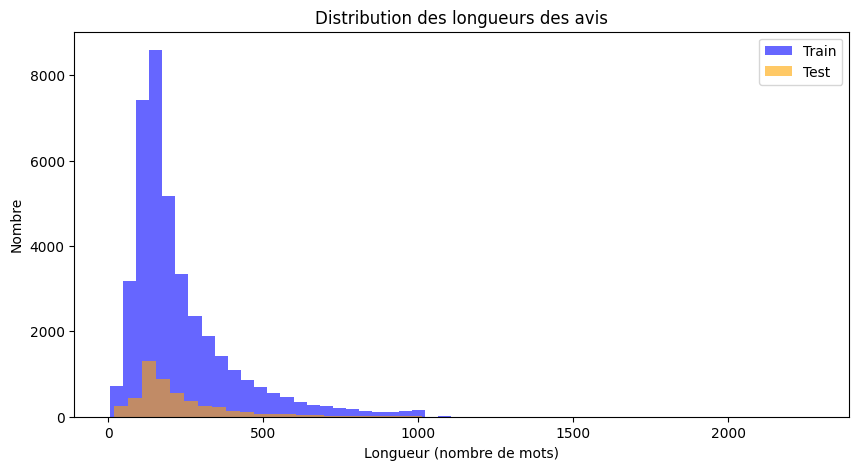

In [9]:
# Fonction pour calculer la longueur des avis
def review_lengths(data):
    return [len(review.split()) for _, review in data]

train_lengths = review_lengths(train_datas)
test_lengths = review_lengths(test_datas)

plt.figure(figsize=(10, 5))
plt.hist(train_lengths, bins=50, alpha=0.6, label='Train', color='blue')
plt.hist(test_lengths, bins=50, alpha=0.6, label='Test', color='orange')
plt.title('Distribution des longueurs des avis')
plt.xlabel('Longueur (nombre de mots)')
plt.ylabel('Nombre')
plt.legend()
plt.show()


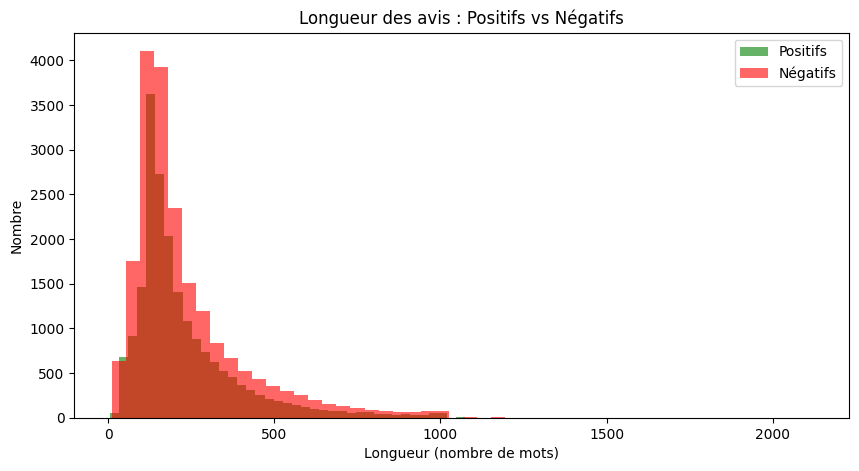

In [10]:
pos_lengths = [len(review.split()) for label, review in train_datas if label == 1]
neg_lengths = [len(review.split()) for label, review in train_datas if label == 2]

plt.figure(figsize=(10, 5))
plt.hist(pos_lengths, bins=50, alpha=0.6, label='Positifs', color='green')
plt.hist(neg_lengths, bins=50, alpha=0.6, label='Négatifs', color='red')
plt.title('Longueur des avis : Positifs vs Négatifs')
plt.xlabel('Longueur (nombre de mots)')
plt.ylabel('Nombre')
plt.legend()
plt.show()


### Basic loaders

In [11]:
def basic_collate_batch(batch):
    text_list, label_list = [], []
    for label, text in batch:
        text_list.append(torch.tensor(basic_vocab(basic_tokenizer(text)), dtype=torch.int32))
        label_list.append(label-1)
    text_tensor = pad_sequence(text_list, batch_first=True, padding_value=BASIC_PAD_IDX)
    label_tensor = torch.tensor(label_list, dtype=torch.float32)
    return text_tensor, label_tensor

In [12]:
basic_train_loader = DataLoader(train_datas, batch_size=BATCH_SIZE, shuffle=True, collate_fn=basic_collate_batch, drop_last=True)
basic_val_loader = DataLoader(val_datas, batch_size=BATCH_SIZE, shuffle=True, collate_fn=basic_collate_batch, drop_last=False)
basic_test_loader = DataLoader(test_datas, batch_size=1, shuffle=False, collate_fn=basic_collate_batch, drop_last=False)

# Print loaders' sizes
print(f"Size train loader : {len(basic_train_loader.dataset)}")
print(f"Size validation loader : {len(basic_val_loader.dataset)}")
print(f"Size test loader : {len(basic_test_loader.dataset)}")

Size train loader : 39665
Size validation loader : 4958
Size test loader : 4959


### Bert loaders

In [13]:
bert_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
BERT_PAD_IDX = bert_tokenizer.pad_token_id # 0

def bert_collate_batch(batch):
    text_list, label_list = [], []
    for label, text in batch:
        item = bert_tokenizer(text, truncation=True, return_tensors="pt")  # could add: padding=True
        text_list.append(item["input_ids"].squeeze(0))
        label_list.append(label-1)  
    padded_text_ids = pad_sequence(text_list, batch_first=True, padding_value=BERT_PAD_IDX)
    label_list = torch.tensor(label_list, dtype=torch.float32)
    return padded_text_ids, label_list

# To get the attention from item use:
# item["attention_mask"]        

In [14]:
bert_train_loader = DataLoader(train_datas, batch_size=BATCH_SIZE, shuffle=True, collate_fn=bert_collate_batch, drop_last=True)
bert_val_loader = DataLoader(val_datas, batch_size=BATCH_SIZE, shuffle=True, collate_fn=bert_collate_batch, drop_last=False)
bert_test_loader = DataLoader(test_datas, batch_size=1, shuffle=False, collate_fn=bert_collate_batch, drop_last=False)

# Print loaders' sizes
print(f"Size train loader : {len(bert_train_loader.dataset)}")
print(f"Size validation loader : {len(bert_val_loader.dataset)}")
print(f"Size test loader : {len(bert_test_loader.dataset)}")

Size train loader : 39665
Size validation loader : 4958
Size test loader : 4959


## Loading pre-trained embedings

### Glove (to be used with the basic vocab)

In [15]:
def load_glove_embeddings(vocab, path=GLOVE_PATH, embedding_dim=EMBEDDING_DIM):
    # Load GloVe embeddings into a dictionary
    glove_embeddings = {}
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = torch.tensor([float(val) for val in values[1:embedding_dim+1]], dtype=torch.float32) # works if we choose an emb dim < 100
            glove_embeddings[word] = vector

    # Create a weights matrix for words in vocab
    weights_matrix = torch.zeros((len(vocab), embedding_dim))
    for word, idx in vocab.get_stoi().items():
        if word in glove_embeddings:
            weights_matrix[idx] = glove_embeddings[word]
        else:
            weights_matrix[idx] = torch.zeros(embedding_dim)
    return weights_matrix

GLOVE_EMBS = load_glove_embeddings(basic_vocab)
print(GLOVE_EMBS.shape)

torch.Size([100683, 100])


### Bert

In [16]:
bert_model = DistilBertModel.from_pretrained("distilbert-base-uncased")
BERT_EMBS = bert_model.embeddings.word_embeddings.weight
BERT_EMB_SIZE = 768
print(BERT_EMBS.shape) 

torch.Size([30522, 768])


## Define models

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, vocab_size=BASIC_VOCAB_SIZE, embed_size=EMBEDDING_DIM, hidden_size=HIDDEN_DIM, output_size=OUTPUT_DIM, dropout=DROPOUT, pretrained_embs=None, pretrained=False):
        super(MLPClassifier, self).__init__()
        
        # Embedding layer
        if pretrained:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embs, freeze=True)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.fc1 = nn.Linear(embed_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)  
        self.fc3 = nn.Linear(hidden_size // 2, output_size)  
        
        self.dropout = nn.Dropout(dropout)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)  # (batch_size, seq_len, embed_size)
        x = embedded.mean(dim=1) 
        
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return self.sigmoid(x)

In [ ]:
class CNN1DClassifier(nn.Module):
    def __init__(self, vocab_size=BASIC_VOCAB_SIZE, embed_size=EMBEDDING_DIM, pretrained_embs=None, pretrained=False):
        super(CNN1DClassifier, self).__init__()
        
        if pretrained:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embs, freeze=True)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.conv1 = nn.Conv1d(in_channels=embed_size, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 1)
        
        self.dropout = nn.Dropout(DROPOUT)
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)  # Shape: (batch_size, seq_len, embed_size)
        embedded = embedded.permute(0, 2, 1)  # Convert to (batch_size, embed_size, seq_len) for Conv1D
        
        x = F.relu(self.conv1(embedded))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        # Global max pooling
        x = F.adaptive_max_pool1d(x, 1).squeeze(2)  # Shape: (batch_size, out_channels)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return self.sigmoid(x)

In [18]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size=BASIC_VOCAB_SIZE, embed_size=EMBEDDING_DIM, hidden_size=HIDDEN_DIM,
                 output_size=OUTPUT_DIM, dropout=DROPOUT, num_layers=NUM_LAYERS, pretrained_embs=GLOVE_EMBS, pretrained=False):
        super(LSTMClassifier, self).__init__()
        if pretrained:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embs, freeze=True) # To ensure weights are not trained
        else:
            self.embedding = nn.Embedding(vocab_size, embed_size)

        self.add_fc = False
        if pretrained and pretrained_embs.size(1) != embed_size:
            self.fc1 = nn.Linear(pretrained_embs.size(1), embed_size)
            self.add_fc = True
            
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        if self.add_fc:
            embedded = self.fc1(embedded)
        lstm_out, (hidden, _) = self.lstm(embedded)
        output = self.fc2(hidden[-1])
        return self.sigmoid(output)

In [19]:
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size=BASIC_VOCAB_SIZE, embed_size=EMBEDDING_DIM, hidden_size=HIDDEN_DIM,
                 output_size=OUTPUT_DIM, dropout=DROPOUT, num_layers=NUM_LAYERS, pretrained_embs=GLOVE_EMBS, pretrained=False):
        super(GRUClassifier, self).__init__()
        if pretrained:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embs, freeze=True) # To ensure weights are not trained
        else:
            self.embedding = nn.Embedding(vocab_size, embed_size)

        self.add_fc = False
        if pretrained and pretrained_embs.size(1) != embed_size:
            self.fc1 = nn.Linear(pretrained_embs.size(1), embed_size)
            self.add_fc = True
            
        self.gru = nn.GRU(embed_size, hidden_size, num_layers=num_layers,
                          dropout=dropout, batch_first=True)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        if self.add_fc:
            embedded = self.fc1(embedded)
        gru_out, _ = self.gru(embedded)
        last_hidden_state = gru_out[:, -1, :]
        output = self.fc2(last_hidden_state)
        return self.sigmoid(output)

In [20]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size = BASIC_VOCAB_SIZE, embed_size = EMBEDDING_DIM, hidden_size = HIDDEN_DIM, output_size = OUTPUT_DIM, num_layers=NUM_LAYERS, dropout=DROPOUT, pretrained_embs=None,
                  pretrained=False):
        super(RNNClassifier, self).__init__()
        
        if pretrained:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embs, freeze=True)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.add_fc = False
        if pretrained and pretrained_embs.size(1) != embed_size:
            self.fc1 = nn.Linear(pretrained_embs.size(1), embed_size)
            self.add_fc = True
        
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True, nonlinearity='tanh')
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        if self.add_fc:
            embedded = self.fc1(embedded)
        
        rnn_out, hidden = self.rnn(embedded)
        last_hidden_state = hidden[-1]
        output = self.fc2(last_hidden_state)
        return self.sigmoid(output)


## Train and test functions

In [21]:
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
# Train function
def train_epoch(model, data_loader, criterion, optimizer):
    model.train()
    total_loss, total_acc = 0, 0
    size_loader = 0
    f1_metric = BinaryF1Score().to(DEVICE)
    for text, labels in tqdm(data_loader):
        text, labels = text.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        output = model(text).squeeze(dim=1) # could use .squeeze() if drop_last=True
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # Metrics part
        total_loss += loss.item()
        total_acc += ((output >= 0.5) == labels).sum().item()
        size_loader += labels.size(0)
        preds = (output >= 0.5)
        f1_metric.update(preds, labels)
    
    f1 = f1_metric.compute()
    f1_metric.reset()
    return total_loss / size_loader, total_acc / size_loader, f1

# Test function
def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss, total_acc = 0, 0
    size_loader = 0
    f1_metric = BinaryF1Score().to(DEVICE)
    with torch.no_grad():
        for text, labels in tqdm(data_loader):
            text, labels = text.to(DEVICE), labels.to(DEVICE)
            output = model(text).squeeze(dim=1)
            loss = criterion(output, labels)

            # Metrics part
            total_loss += loss.item()
            total_acc += ((output >= 0.5) == labels).sum().item()
            size_loader += labels.size(0)
            preds = (output >= 0.5)
            f1_metric.update(preds, labels)
    
    f1 = f1_metric.compute()
    f1_metric.reset()
    return total_loss / size_loader, total_acc / size_loader, f1
    
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## MLP

### Basic training

Number of trainable params: 10089549


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 1/5 | Train Loss: 0.4748 | Train Acc: 0.7478 | Train F1: 0.7506 | Val Loss: 0.3184 | Val Acc: 0.8626 | Val F1: 0.8572 | Time: 47.94s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 2/5 | Train Loss: 0.2675 | Train Acc: 0.8928 | Train F1: 0.8930 | Val Loss: 0.2755 | Val Acc: 0.8871 | Val F1: 0.8846 | Time: 51.72s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 3/5 | Train Loss: 0.2133 | Train Acc: 0.9183 | Train F1: 0.9185 | Val Loss: 0.2596 | Val Acc: 0.8985 | Val F1: 0.8999 | Time: 50.02s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 4/5 | Train Loss: 0.1759 | Train Acc: 0.9346 | Train F1: 0.9348 | Val Loss: 0.3364 | Val Acc: 0.8395 | Val F1: 0.8237 | Time: 46.78s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 5/5 | Train Loss: 0.1448 | Train Acc: 0.9468 | Train F1: 0.9469 | Val Loss: 0.3129 | Val Acc: 0.8758 | Val F1: 0.8693 | Time: 46.00s


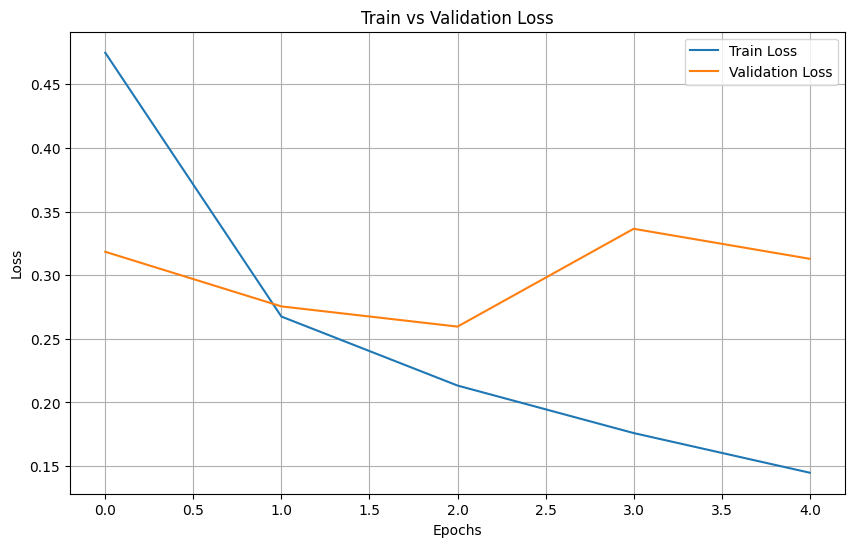

In [30]:
model_mlp = MLPClassifier(pretrained=False)
model_mlp.to(DEVICE)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model_mlp.parameters(), lr=1e-3)
print(f"Number of trainable params: {count_trainable_parameters(model_mlp)}")
train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    train_loss, train_acc, train_f1 = train_epoch(model_mlp, basic_train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    val_loss, val_acc, val_f1 = evaluate(model_mlp, basic_val_loader, criterion)
    val_losses.append(val_loss)
    end_time = time.time()

    print(f"Epoch: {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Train F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Time: {end_time-start_time:.2f}s")
plot_loss(train_losses, val_losses)


In [55]:
test_loss, test_acc_mlp, test_f1_mlp = evaluate(model_mlp, basic_test_loader, criterion)
print(f"Ensemble Model - Loss: {test_loss:.4f}, Accuracy: {test_acc_mlp:.4f}, F1 Score: {test_f1_mlp:.4f}")

  0%|          | 0/4959 [00:00<?, ?it/s]

Ensemble Model - Loss: 0.4063, Accuracy: 0.8990, F1 Score: 0.8960


## CNN 1D

### Basic training

Number of trainable params: 10312141


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 1/5 | Train Loss: 0.5526 | Train Acc: 0.6976 | Train F1: 0.7137 | Val Loss: 0.4401 | Val Acc: 0.8040 | Val F1: 0.7987 | Time: 112.81s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 2/5 | Train Loss: 0.3384 | Train Acc: 0.8567 | Train F1: 0.8584 | Val Loss: 0.3073 | Val Acc: 0.8725 | Val F1: 0.8820 | Time: 61.87s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 3/5 | Train Loss: 0.2256 | Train Acc: 0.9127 | Train F1: 0.9135 | Val Loss: 0.2875 | Val Acc: 0.8885 | Val F1: 0.8946 | Time: 62.63s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 4/5 | Train Loss: 0.1546 | Train Acc: 0.9438 | Train F1: 0.9440 | Val Loss: 0.2896 | Val Acc: 0.8961 | Val F1: 0.8961 | Time: 57.20s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 5/5 | Train Loss: 0.0988 | Train Acc: 0.9660 | Train F1: 0.9662 | Val Loss: 0.3186 | Val Acc: 0.8905 | Val F1: 0.8926 | Time: 59.49s


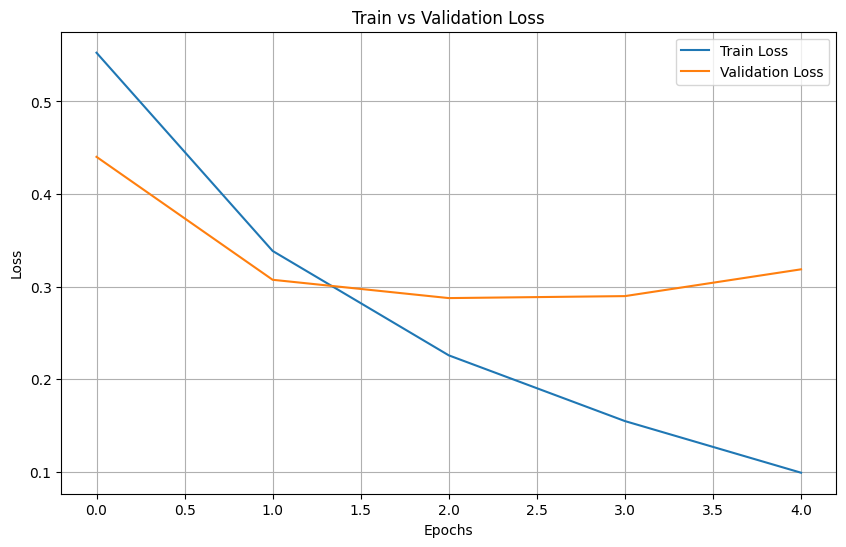

In [33]:
model_cnn = CNN1DClassifier(pretrained=False)
model_cnn.to(DEVICE)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model_cnn.parameters(), lr=1e-3)
print(f"Number of trainable params: {count_trainable_parameters(model_cnn)}")
train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    train_loss, train_acc, train_f1 = train_epoch(model_cnn, basic_train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    val_loss, val_acc, val_f1 = evaluate(model_cnn, basic_val_loader, criterion)
    val_losses.append(val_loss)
    end_time = time.time()

    print(f"Epoch: {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Train F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Time: {end_time-start_time:.2f}s")
plot_loss(train_losses, val_losses)

In [56]:
test_loss, test_acc_cnn, test_f1_cnn = evaluate(model_cnn, basic_test_loader, criterion)
print(f"Ensemble Model - Loss: {test_loss:.4f}, Accuracy: {test_acc_cnn:.4f}, F1 Score: {test_f1_cnn:.4f}")

  0%|          | 0/4959 [00:00<?, ?it/s]

Ensemble Model - Loss: 0.3381, Accuracy: 0.8855, F1 Score: 0.8860


## RNN

### Basic training

Number of trainable params: 10130893


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 1/5 | Train Loss: 0.6983 | Train Acc: 0.5058 | Train F1: 0.5095 | Val Loss: 0.6949 | Val Acc: 0.4891 | Val F1: 0.0224 | Time: 65.27s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 2/5 | Train Loss: 0.6986 | Train Acc: 0.4974 | Train F1: 0.5018 | Val Loss: 0.6984 | Val Acc: 0.5101 | Val F1: 0.6716 | Time: 67.46s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 3/5 | Train Loss: 0.6985 | Train Acc: 0.4997 | Train F1: 0.4962 | Val Loss: 0.6956 | Val Acc: 0.4913 | Val F1: 0.0922 | Time: 64.73s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 4/5 | Train Loss: 0.6969 | Train Acc: 0.5073 | Train F1: 0.5027 | Val Loss: 0.6912 | Val Acc: 0.5165 | Val F1: 0.6649 | Time: 66.65s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 5/5 | Train Loss: 0.6962 | Train Acc: 0.5095 | Train F1: 0.5037 | Val Loss: 0.6909 | Val Acc: 0.5151 | Val F1: 0.6723 | Time: 64.63s


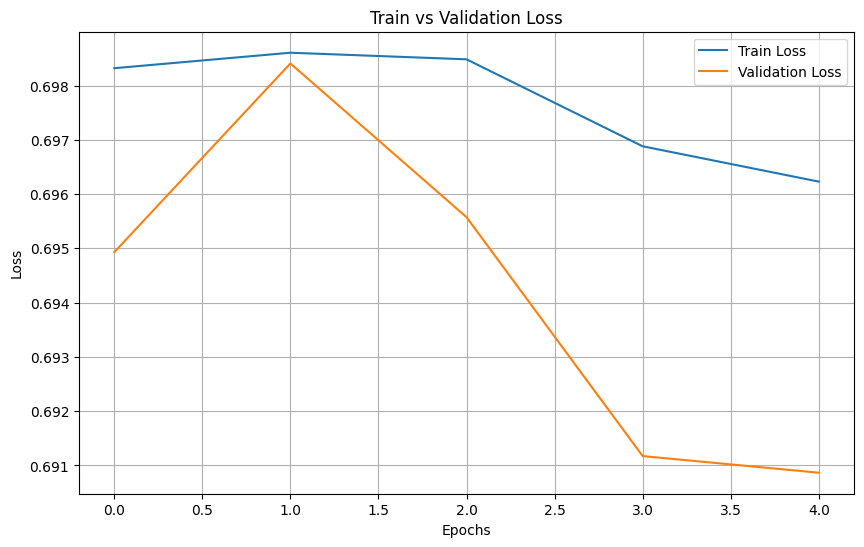

In [34]:
model_rnn = RNNClassifier(pretrained=False)
model_rnn.to(DEVICE)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model_rnn.parameters(), lr=1e-3)
print(f"Number of trainable params: {count_trainable_parameters(model_rnn)}")
train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    train_loss, train_acc, train_f1 = train_epoch(model_rnn, basic_train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    val_loss, val_acc, val_f1 = evaluate(model_rnn, basic_val_loader, criterion)
    val_losses.append(val_loss)
    end_time = time.time()

    print(f"Epoch: {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Train F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Time: {end_time-start_time:.2f}s")
plot_loss(train_losses, val_losses)

In [57]:
test_loss, test_acc_rnn, test_f1_rnn = evaluate(model_rnn, basic_test_loader, criterion)
print(f"Ensemble Model - Loss: {test_loss:.4f}, Accuracy: {test_acc_rnn:.4f}, F1 Score: {test_f1_rnn:.4f}")

  0%|          | 0/4959 [00:00<?, ?it/s]

Ensemble Model - Loss: 0.6903, Accuracy: 0.5257, F1 Score: 0.6003


### Bert training

In [ ]:
model = RNNClassifier(pretrained=True, pretrained_embs=BERT_EMBS, embed_size=BERT_EMB_SIZE)
model.to(DEVICE)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
print(f"Number of trainable params: {count_trainable_parameters(model)}")

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    train_loss, train_acc, train_f1 = train_epoch(model, bert_train_loader, criterion, optimizer)
    val_loss, val_acc, val_f1 = evaluate(model, bert_val_loader, criterion)
    end_time = time.time()

    print(f"Epoch: {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Train F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Time: {end_time-start_time:.2f}s")

## GRU

### Basic training

Number of trainable params: 10255821


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 1/5 | Train Loss: 0.6575 | Train Acc: 0.5553 | Train F1: 0.5612 | Val Loss: 0.3397 | Val Acc: 0.8592 | Val F1: 0.8666 | Time: 75.43s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 2/5 | Train Loss: 0.2578 | Train Acc: 0.8959 | Train F1: 0.8966 | Val Loss: 0.2313 | Val Acc: 0.9096 | Val F1: 0.9138 | Time: 74.73s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 3/5 | Train Loss: 0.1445 | Train Acc: 0.9472 | Train F1: 0.9474 | Val Loss: 0.2331 | Val Acc: 0.9131 | Val F1: 0.9151 | Time: 62.54s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 4/5 | Train Loss: 0.0770 | Train Acc: 0.9755 | Train F1: 0.9756 | Val Loss: 0.2840 | Val Acc: 0.9092 | Val F1: 0.9117 | Time: 57.68s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 5/5 | Train Loss: 0.0459 | Train Acc: 0.9863 | Train F1: 0.9863 | Val Loss: 0.3382 | Val Acc: 0.9080 | Val F1: 0.9103 | Time: 70.76s


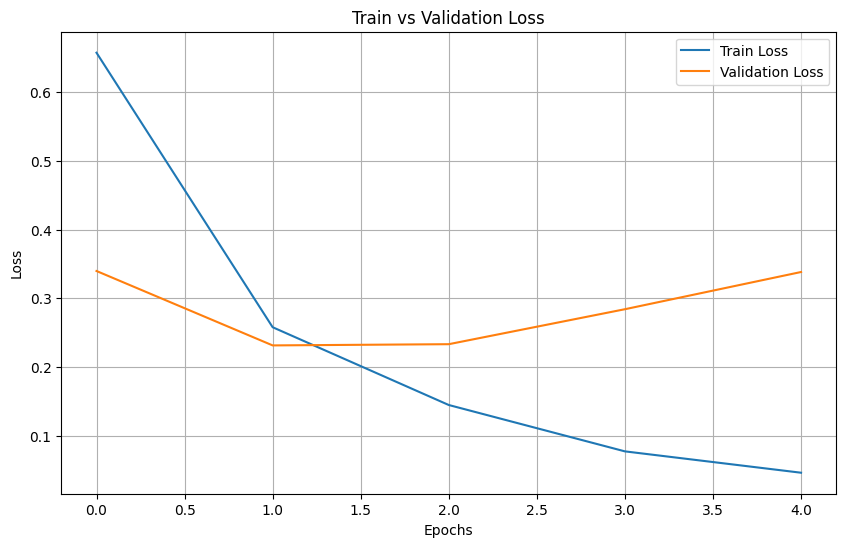

In [35]:
model_gru = GRUClassifier(pretrained=False)
model_gru.to(DEVICE)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model_gru.parameters(), lr=1e-3)
print(f"Number of trainable params: {count_trainable_parameters(model_gru)}")
train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    train_loss, train_acc, train_f1 = train_epoch(model_gru, basic_train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    val_loss, val_acc, val_f1 = evaluate(model_gru, basic_val_loader, criterion)
    val_losses.append(val_loss)
    end_time = time.time()

    print(f"Epoch: {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Train F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Time: {end_time-start_time:.2f}s")
plot_loss(train_losses, val_losses)

In [59]:
test_loss, test_acc_gru, test_f1_gru = evaluate(model_gru, basic_test_loader, criterion)
print(f"Ensemble Model - Loss: {test_loss:.4f}, Accuracy: {test_acc_gru:.4f}, F1 Score: {test_f1_gru:.4f}")

  0%|          | 0/4959 [00:00<?, ?it/s]

Ensemble Model - Loss: 0.3860, Accuracy: 0.8972, F1 Score: 0.8990


### Bert training

In [36]:
model = GRUClassifier(pretrained=True, pretrained_embs=BERT_EMBS, embed_size=BERT_EMB_SIZE)
model.to(DEVICE)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
print(f"Number of trainable params: {count_trainable_parameters(model)}")

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    train_loss, train_acc, train_f1 = train_epoch(model, bert_train_loader, criterion, optimizer)
    val_loss, val_acc, val_f1 = evaluate(model, bert_val_loader, criterion)
    end_time = time.time()

    print(f"Epoch: {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Train F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Time: {end_time-start_time:.2f}s")

Number of trainable params: 444033


  0%|          | 0/4958 [00:00<?, ?it/s]

KeyboardInterrupt: 

## LSTM

### Basic

Number of trainable params: 10318285


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 1/5 | Train Loss: 0.6907 | Train Acc: 0.5123 | Train F1: 0.3786 | Val Loss: 0.6842 | Val Acc: 0.5147 | Val F1: 0.1877 | Time: 87.74s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 2/5 | Train Loss: 0.4348 | Train Acc: 0.7989 | Train F1: 0.7989 | Val Loss: 0.2925 | Val Acc: 0.8814 | Val F1: 0.8856 | Time: 82.30s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 3/5 | Train Loss: 0.2351 | Train Acc: 0.9090 | Train F1: 0.9094 | Val Loss: 0.2773 | Val Acc: 0.8913 | Val F1: 0.8988 | Time: 83.29s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 4/5 | Train Loss: 0.1578 | Train Acc: 0.9441 | Train F1: 0.9443 | Val Loss: 0.2464 | Val Acc: 0.9062 | Val F1: 0.9093 | Time: 84.97s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 5/5 | Train Loss: 0.1030 | Train Acc: 0.9668 | Train F1: 0.9670 | Val Loss: 0.2902 | Val Acc: 0.9054 | Val F1: 0.9079 | Time: 82.94s


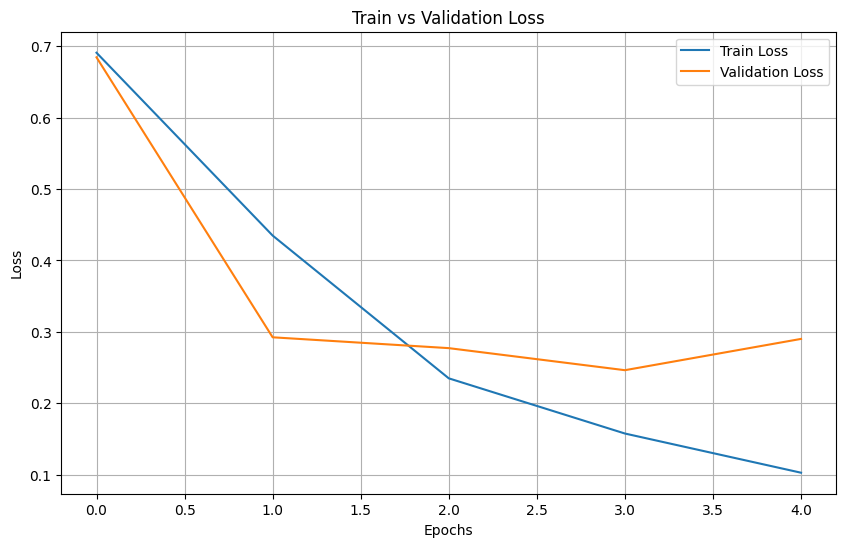

In [37]:
model_lstm = LSTMClassifier(pretrained=False)
model_lstm.to(DEVICE)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model_lstm.parameters(), lr=1e-3)
print(f"Number of trainable params: {count_trainable_parameters(model_lstm)}")
train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    train_loss, train_acc, train_f1 = train_epoch(model_lstm, basic_train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    val_loss, val_acc, val_f1 = evaluate(model_lstm, basic_val_loader, criterion)
    val_losses.append(val_loss)
    end_time = time.time()

    print(f"Epoch: {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Train F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Time: {end_time-start_time:.2f}s")
plot_loss(train_losses, val_losses)

In [60]:
test_loss, test_acc_lstm, test_f1_lstm = evaluate(model_lstm, basic_test_loader, criterion)
print(f"Ensemble Model - Loss: {test_loss:.4f}, Accuracy: {test_acc_lstm:.4f}, F1 Score: {test_f1_lstm:.4f}")

  0%|          | 0/4959 [00:00<?, ?it/s]

Ensemble Model - Loss: 0.2847, Accuracy: 0.8992, F1 Score: 0.8989


### Bert

In [ ]:
model = LSTMClassifier(pretrained=True, pretrained_embs=BERT_EMBS, embed_size=BERT_EMB_SIZE)
model.to(DEVICE)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
print(f"Number of trainable params: {count_trainable_parameters(model)}")

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    train_loss, train_acc, train_f1 = train_epoch(model, bert_train_loader, criterion, optimizer)
    val_loss, val_acc, val_f1 = evaluate(model, bert_val_loader, criterion)
    end_time = time.time()

    print(f"Epoch: {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Train F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} | Time: {end_time-start_time:.2f}s")

Number of trainable params: 592001


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 1/5 | Train Loss: 0.6934 | Train Acc: 0.5022 | Train F1: 0.5773 | Val Loss: 0.6931 | Val Acc: 0.5097 | Val F1: 0.2671 | Time: 79.57s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 2/5 | Train Loss: 0.6932 | Train Acc: 0.5017 | Train F1: 0.6089 | Val Loss: 0.6932 | Val Acc: 0.4954 | Val F1: 0.6500 | Time: 76.42s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 3/5 | Train Loss: 0.6919 | Train Acc: 0.5148 | Train F1: 0.5162 | Val Loss: 0.6930 | Val Acc: 0.5081 | Val F1: 0.0008 | Time: 78.42s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 4/5 | Train Loss: 0.6935 | Train Acc: 0.4983 | Train F1: 0.5428 | Val Loss: 0.6965 | Val Acc: 0.4921 | Val F1: 0.6596 | Time: 105.81s


  0%|          | 0/4958 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

Epoch: 5/5 | Train Loss: 0.6934 | Train Acc: 0.4992 | Train F1: 0.5453 | Val Loss: 0.6933 | Val Acc: 0.4921 | Val F1: 0.6596 | Time: 102.14s


## Modèle Globale

In [ ]:
import torch
import torch.nn as nn
from collections import Counter

class EnsembleModel(nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models) 
        
    def forward(self, x):
        predictions = []
        for model in self.models:
            model.eval()  
            with torch.no_grad():
                outputs = model(x) 
                predictions.append((outputs >= 0.5).float()) 
        
        predictions = torch.stack(predictions, dim=0)  # Shape: (num_models, batch_size)
        majority_vote = predictions.sum(dim=0) >= (len(self.models) / 2)
        return majority_vote.float() 


In [64]:
models = [model_mlp, model_cnn, model_rnn, model_gru, model_lstm]
ensemble_model = EnsembleModel(models)
# Évaluez le modèle ensemble
test_loss, test_acc_ensemble, test_f1_ensemble = evaluate(ensemble_model, basic_test_loader, criterion)
print(f"Ensemble Model - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, F1 Score: {test_f1:.4f}")

  0%|          | 0/4959 [00:00<?, ?it/s]

Ensemble Model - Loss: 8.8123, Accuracy: 0.8855, F1 Score: 0.8860


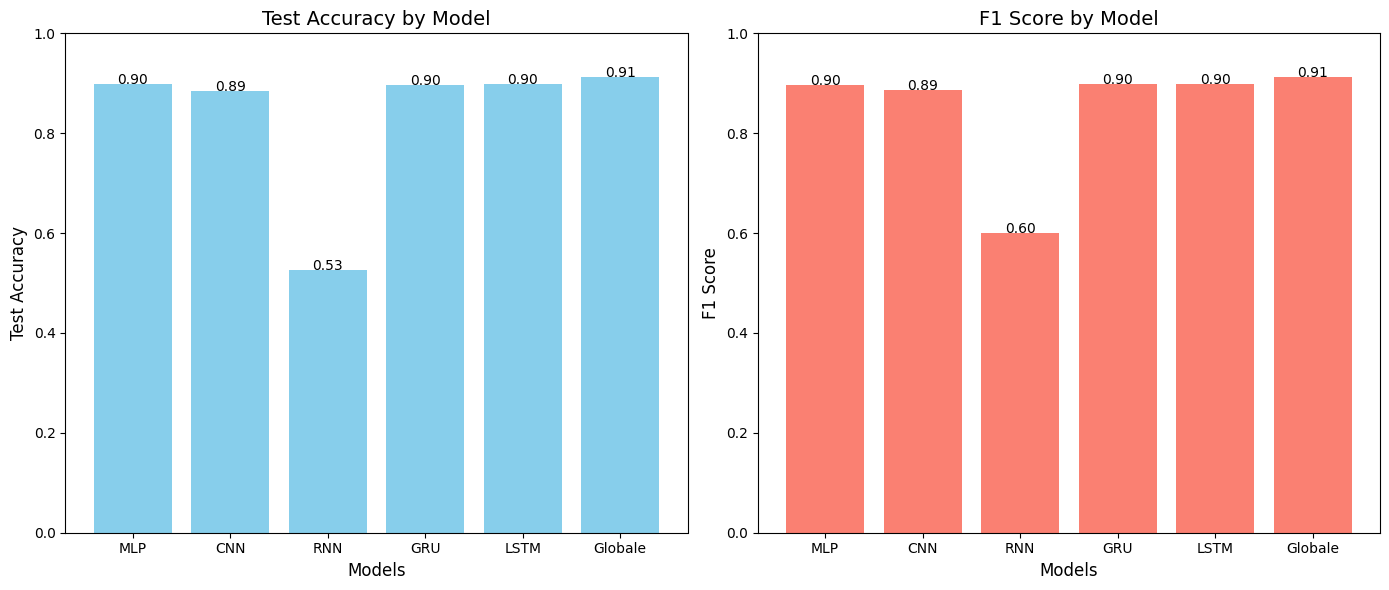

In [69]:
model_list = ['MLP', 'CNN', 'RNN', 'GRU', 'LSTM','Globale']
test_scores = [test_acc_mlp.cpu().item() if hasattr(test_acc_mlp, "cpu") else test_acc_mlp,
               test_acc_cnn.cpu().item() if hasattr(test_acc_cnn, "cpu") else test_acc_cnn,
               test_acc_rnn.cpu().item() if hasattr(test_acc_rnn, "cpu") else test_acc_rnn,
               test_acc_gru.cpu().item() if hasattr(test_acc_gru, "cpu") else test_acc_gru,
               test_acc_lstm.cpu().item() if hasattr(test_acc_lstm, "cpu") else test_acc_lstm,
               test_acc_ensemble.cpu().item() if hasattr(test_acc_ensemble, "cpu") else test_acc_ensemble]

f1_scores = [test_f1_mlp.cpu().item() if hasattr(test_f1_mlp, "cpu") else test_f1_mlp,
             test_f1_cnn.cpu().item() if hasattr(test_f1_cnn, "cpu") else test_f1_cnn,
             test_f1_rnn.cpu().item() if hasattr(test_f1_rnn, "cpu") else test_f1_rnn,
             test_f1_gru.cpu().item() if hasattr(test_f1_gru, "cpu") else test_f1_gru,
             test_f1_lstm.cpu().item() if hasattr(test_f1_lstm, "cpu") else test_f1_lstm,
             test_f1_ensemble.cpu().item() if hasattr(test_f1_ensemble, "cpu") else test_f1_ensemble]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Premier plot : Test Accuracy
axes[0].bar(model_list, test_scores, color='skyblue')
axes[0].set_title('Test Accuracy by Model', fontsize=14)
axes[0].set_xlabel('Models', fontsize=12)
axes[0].set_ylabel('Test Accuracy', fontsize=12)
axes[0].set_ylim(0, 1)
for i, acc in enumerate(test_scores):
    axes[0].text(i, acc, f'{acc:.2f}', ha='center', fontsize=10)

# Deuxième plot : F1 Score
axes[1].bar(model_list, f1_scores, color='salmon')
axes[1].set_title('F1 Score by Model', fontsize=14)
axes[1].set_xlabel('Models', fontsize=12)
axes[1].set_ylabel('F1 Score', fontsize=12)
axes[1].set_ylim(0, 1)
for i, f1 in enumerate(f1_scores):
    axes[1].text(i, f1 , f'{f1:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()